In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Train with Pseudo Labels

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import gc
import os
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics
from scipy.special import softmax

import torch
import torch.nn as nn
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

import pretrainedmodels
from adamp import AdamP, SGDP
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding

import dataset
import engine
import models
import optimizers
import utils
# from optimizers import RAdam, RAdam_4step
from optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

In [4]:
SEED = 42
utils.seed_everything(SEED)

## Data

In [5]:
device = torch.device("cuda")
DATA_PATH = Path("../input")
# data_dir = Path("../input/pl3")
df = pd.read_csv(DATA_PATH / "train.csv")
df.shape

(2048, 787)

## Train

### Definition

#### Train folds function

In [8]:
def run(model_name, optim_name, epochs, lr, checkpoint, batch_size=256, swa=False, label_smooth=False, rgb=True):
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))
    
    for fold in range(5):
#         train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
#         valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
        train_indices = np.load(DATA_PATH / f"train_idx-fold{fold}.npy")
        valid_indices = np.load(DATA_PATH / f"valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, rgb=rgb)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices, rgb=rgb)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4*batch_size)

        model = models.get_model(model_name).to(device)
        optimizer = optimizers.get_optimizer(optim_name, model, lr)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[81, 122], gamma=0.1)
#         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scheduler = LinearWarmupCosineAnnealingLR(
            optimizer, warmup_epochs=10, max_epochs=epochs
        )
        scaler = torch.cuda.amp.GradScaler()

        train_accuracies = []
        valid_accuracies = []
        best_accuracy = 0
        checkpoint = pathlib.Path(checkpoint)
        if not checkpoint.exists(): checkpoint.mkdir(parents=True)
        
        # SWA Model
        if swa:
            swa_start = int(0.75 * epochs)
            swa_model = AveragedModel(model)
            swa_scheduler = SWALR(optimizer, swa_lr=lr * (0.1)**2)

        for epoch in range(epochs):

            # Train
            train_loss, train_accuracy = engine.train(train_loader, model, optimizer, device, scaler, label_smooth=label_smooth)
            train_accuracies.append(train_accuracy)

            # Validate
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, model, device)
            valid_preds = np.argmax(valid_probs, axis=1)
            valid_accuracy = metrics.accuracy_score(valid_targs, valid_preds)
            valid_accuracies.append(valid_accuracy)

            if swa and swa_start > epoch:
                swa_model.update_parameters(model)
                swa_scheduler.step()
            else:
                scheduler.step()

            # Checkpoint
            is_best = best_accuracy > best_accuracy
            if is_best:
                best_accuracy = valid_accuracy
            if swa:
                utils.save_checkpoint({
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "swa_state_dict": swa_model.state_dict(),
                    "acc": valid_accuracy,
                    "best_acc": best_accuracy,
                    "optimizer": optimizer.state_dict(),
                    }, is_best, checkpoint,
                    filename=f"checkpoint_e{epoch}_top1_{train_accuracy:.3f}_{valid_accuracy:.3f}.pth",
                )
            else:
                utils.save_checkpoint({
                    "epoch": epoch,
                    "state_dict": model.state_dict(),
                    "acc": valid_accuracy,
                    "best_acc": best_accuracy,
                    "optimizer": optimizer.state_dict(),
                    }, is_best, checkpoint,
                    filename=f"checkpoint_e{epoch}_top1_{train_accuracy:.3f}_{valid_accuracy:.3f}.pth",
                )
                
            if epoch % 10 == 0:
                print(f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}")

        # Update BN stats
        if swa:
            swa_model = swa_model.cpu()
            update_bn(train_loader, swa_model)
            swa_model.to(device)

        # Validation
        if swa:
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, swa_model, device)
        else:
            valid_probs, valid_targs, valid_loss = engine.evaluate(valid_loader, model, device)
        valid_preds = np.argmax(valid_probs, axis=1)
        valid_accuracy = metrics.accuracy_score(valid_targs, valid_preds)
        print(f"Fold={fold}, Validation Accuracy={valid_accuracy}")

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.xlabel("Accuracy")
        plt.ylabel("Epoch")
        plt.legend()
        plt.show()

        # oof prediction
        oof[valid_indices] = softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs
        
        if swa:
            torch.save(swa_model.state_dict(), f"../models/swa-{model_name}-{fold}.pth")
        else:
            torch.save(model.state_dict(), f"../models/{model_name}-{fold}.pth")

        # Cleanup
        del model
        torch.cuda.empty_cache()
        gc.collect()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    
    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))
    
    if swa:
        np.save(f"../input/processed/oof-train-swa-{model_name}", oof)
    else:
        np.save(f"../input/processed/oof-train-{model_name}", oof)

    return oof, targs

### Baseline

In [ ]:
# Baseline
EPOCHS = 200
oof = np.zeros((len(df), 10))
targs_oof = np.zeros(len(df))
SWA = False

for fold in range(5):
    train_indices = np.load(f"../input/pl3/train_idx-fold{fold}.npy")
    valid_indices = np.load(f"../input/pl3/valid_idx-fold{fold}.npy")
    train_dataset = dataset.EMNISTDataset(df, train_indices)
    valid_dataset = dataset.EMNISTDataset(df, valid_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

    model = models.Model().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler()
    
    # SWA
    if SWA:
        swa_start = int(0.75 * EPOCHS)
        swa_scheduler = SWALR(optimizer, swa_lr=1e-4)
        swa_model = AveragedModel(model).to(device)
    
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(EPOCHS):
        
        # Train
        engine.train(train_loader, model, optimizer, device, scaler, clip_grad=False)
        
        # Get training accuracy
        train_probs, train_targs = engine.evaluate(train_loader, model, device)
        train_preds = np.argmax(train_probs, axis=1)
        train_accuracy = metrics.accuracy_score(train_targs, train_preds)
        train_accuracies.append(train_accuracy)
        
        # Get validation accuracy
        preds, targs = engine.evaluate(valid_loader, model, device)
        preds = np.argmax(preds, axis=1)
        accuracy = metrics.accuracy_score(targs, preds)
        valid_accuracies.append(accuracy)
        
        if SWA and epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch={epoch}, Accuracy={accuracy}")
    
    if SWA:
        # Update BN-statistics
        swa_model = swa_model.cpu()
        update_bn(train_loader, swa_model)
        swa_model.to(device)
    
    # Validation
    probs, targs = engine.evaluate(valid_loader, swa_model if SWA else model, device)
    preds = np.argmax(probs, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"Fold={fold}, Validation Accuracy={accuracy}")
    
    # Plot training curve
    rng = np.arange(len(train_accuracies))
    plt.plot(rng, train_accuracies, label="Train")
    plt.plot(rng, valid_accuracies, label="Validation")
    plt.title(f"Training curve for fold{fold}")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.show()

    oof[valid_indices] = softmax(probs, axis=1)
    targs_oof[valid_indices] = targs
    torch.save(swa_model.state_dict(), f"../models/baseline-swa{SWA}-{fold}.pth")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()

np.save("../input/processed/oof-train-baseline-swa{SWA}", oof)
np.save("../input/processed/targs-train-oof", targs_oof)

In [ ]:
# oof = np.load("../input/processed/oof-train-baseline-swa.npy")
# targs_oof = np.load("../input/processed/targs-train-oof.npy")
preds_oof = np.argmax(oof, axis=1)
accuracy_oof = metrics.accuracy_score(targs_oof, preds_oof)
print(f"CV Accuracy Score={accuracy_oof}")

In [ ]:
EXP = -0.9
s = pd.Series(preds_oof)
vc = s.value_counts().sort_index()
mat = np.diag(vc.astype(np.float32) ** (EXP))

probs_oof_post = oof.dot(mat)
preds_oof_post = np.argmax(probs_oof_post, axis=1)
print(f"Post-processing CV Accuracy score={metrics.accuracy_score(targs_oof, preds_oof_post)}")

### SpinalVGG

Epoch=0, Train loss=2.43912, Valid loss=2.31434, Train Accuracy=0.11043, Validation Accuracy=0.11491
Epoch=10, Train loss=0.88157, Valid loss=0.91070, Train Accuracy=0.86577, Validation Accuracy=0.71883
Epoch=20, Train loss=0.56285, Valid loss=0.65730, Train Accuracy=0.99573, Validation Accuracy=0.80440
Epoch=30, Train loss=0.53596, Valid loss=0.67993, Train Accuracy=0.99695, Validation Accuracy=0.81174
Epoch=40, Train loss=0.52015, Valid loss=0.56549, Train Accuracy=1.00000, Validation Accuracy=0.84841
Epoch=50, Train loss=0.51659, Valid loss=0.55889, Train Accuracy=1.00000, Validation Accuracy=0.85575
Epoch=60, Train loss=0.51599, Valid loss=0.55405, Train Accuracy=1.00000, Validation Accuracy=0.86064
Fold=0, Validation Accuracy=0.8581907090464548


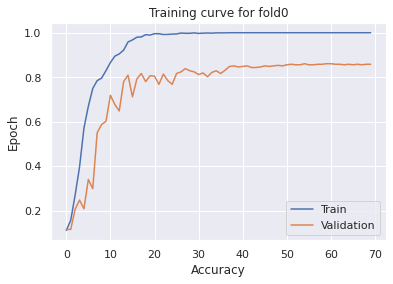

Epoch=0, Train loss=2.44554, Valid loss=2.31038, Train Accuracy=0.10623, Validation Accuracy=0.10244
Epoch=10, Train loss=0.90184, Valid loss=0.97168, Train Accuracy=0.86508, Validation Accuracy=0.71951
Epoch=20, Train loss=0.58363, Valid loss=0.71796, Train Accuracy=0.98352, Validation Accuracy=0.79756
Epoch=30, Train loss=0.53024, Valid loss=0.58293, Train Accuracy=1.00000, Validation Accuracy=0.84634
Epoch=40, Train loss=0.51845, Valid loss=0.53579, Train Accuracy=1.00000, Validation Accuracy=0.85366
Epoch=50, Train loss=0.51708, Valid loss=0.52732, Train Accuracy=1.00000, Validation Accuracy=0.85610
Epoch=60, Train loss=0.51524, Valid loss=0.52974, Train Accuracy=1.00000, Validation Accuracy=0.84634
Fold=1, Validation Accuracy=0.848780487804878


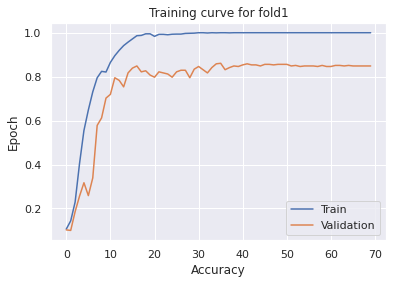

Epoch=0, Train loss=2.45606, Valid loss=2.30102, Train Accuracy=0.09280, Validation Accuracy=0.08780
Epoch=10, Train loss=0.88734, Valid loss=1.47978, Train Accuracy=0.86508, Validation Accuracy=0.61220
Epoch=20, Train loss=0.56383, Valid loss=0.62247, Train Accuracy=0.99389, Validation Accuracy=0.81463
Epoch=30, Train loss=0.54593, Valid loss=0.58726, Train Accuracy=0.99451, Validation Accuracy=0.83659
Epoch=40, Train loss=0.52100, Valid loss=0.55316, Train Accuracy=1.00000, Validation Accuracy=0.84878
Epoch=50, Train loss=0.51753, Valid loss=0.56414, Train Accuracy=1.00000, Validation Accuracy=0.84878
Epoch=60, Train loss=0.51498, Valid loss=0.56309, Train Accuracy=1.00000, Validation Accuracy=0.84146
Fold=2, Validation Accuracy=0.8414634146341463


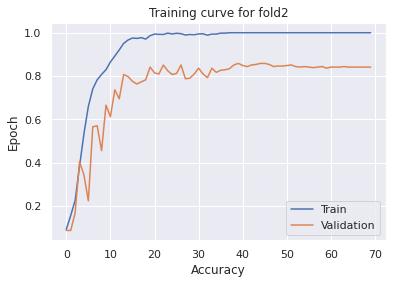

Epoch=0, Train loss=2.43411, Valid loss=2.30283, Train Accuracy=0.10256, Validation Accuracy=0.10976
Epoch=10, Train loss=0.88167, Valid loss=0.92117, Train Accuracy=0.86691, Validation Accuracy=0.74878
Epoch=20, Train loss=0.56757, Valid loss=0.59905, Train Accuracy=0.99267, Validation Accuracy=0.84634
Epoch=30, Train loss=0.52425, Valid loss=0.57112, Train Accuracy=1.00000, Validation Accuracy=0.84390
Epoch=40, Train loss=0.51844, Valid loss=0.56296, Train Accuracy=1.00000, Validation Accuracy=0.85122
Epoch=50, Train loss=0.51701, Valid loss=0.55322, Train Accuracy=1.00000, Validation Accuracy=0.84878
Epoch=60, Train loss=0.51614, Valid loss=0.55048, Train Accuracy=1.00000, Validation Accuracy=0.86585
Fold=3, Validation Accuracy=0.8634146341463415


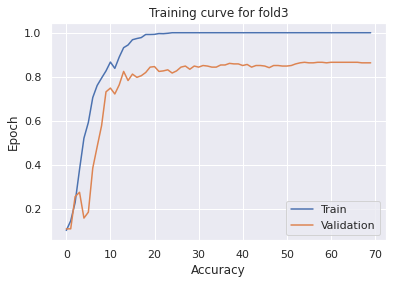

Epoch=0, Train loss=2.47407, Valid loss=2.30558, Train Accuracy=0.09945, Validation Accuracy=0.06601
Epoch=10, Train loss=0.92414, Valid loss=1.32742, Train Accuracy=0.84076, Validation Accuracy=0.62592
Epoch=20, Train loss=0.56800, Valid loss=0.71242, Train Accuracy=0.99268, Validation Accuracy=0.81418
Epoch=30, Train loss=0.53800, Valid loss=0.63020, Train Accuracy=0.99756, Validation Accuracy=0.83374
Epoch=40, Train loss=0.52286, Valid loss=0.58380, Train Accuracy=1.00000, Validation Accuracy=0.82885
Epoch=50, Train loss=0.51811, Valid loss=0.55068, Train Accuracy=1.00000, Validation Accuracy=0.84841
Epoch=60, Train loss=0.51617, Valid loss=0.53644, Train Accuracy=1.00000, Validation Accuracy=0.86064
Fold=4, Validation Accuracy=0.8581907090464548


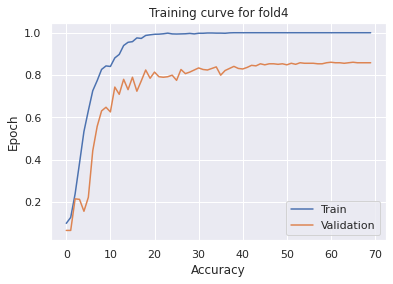

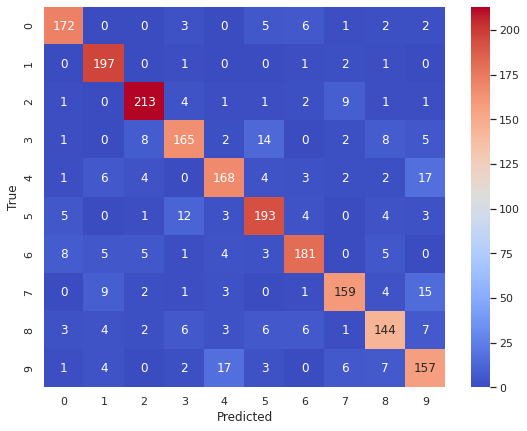

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       191
         1.0       0.88      0.98      0.92       202
         2.0       0.91      0.91      0.91       233
         3.0       0.85      0.80      0.83       205
         4.0       0.84      0.81      0.82       207
         5.0       0.84      0.86      0.85       225
         6.0       0.89      0.85      0.87       212
         7.0       0.87      0.82      0.85       194
         8.0       0.81      0.79      0.80       182
         9.0       0.76      0.80      0.78       197

    accuracy                           0.85      2048
   macro avg       0.85      0.85      0.85      2048
weighted avg       0.85      0.85      0.85      2048

CV Accuracy Score=0.85400390625


In [15]:
# Training Parameters
lr = 0.1
epochs = 70
model_name = "spinalvgg"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}-small"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True, rgb=False)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [17]:
gc.collect()
torch.cuda.empty_cache()

### ResNet

#### ResNet18

Epoch=0, Train loss=2.45975, Valid loss=2.33707, Train Accuracy=0.08847, Validation Accuracy=0.10513
Epoch=10, Train loss=0.36417, Valid loss=2.64278, Train Accuracy=0.89262, Validation Accuracy=0.56724
Epoch=20, Train loss=0.06663, Valid loss=1.69903, Train Accuracy=0.97987, Validation Accuracy=0.69682
Epoch=30, Train loss=0.02568, Valid loss=1.25148, Train Accuracy=0.99573, Validation Accuracy=0.74328
Epoch=40, Train loss=0.00657, Valid loss=1.46375, Train Accuracy=0.99878, Validation Accuracy=0.75795
Epoch=50, Train loss=0.01905, Valid loss=1.33240, Train Accuracy=0.99512, Validation Accuracy=0.77506
Epoch=60, Train loss=0.00033, Valid loss=1.34005, Train Accuracy=1.00000, Validation Accuracy=0.76039
Epoch=70, Train loss=0.00006, Valid loss=1.36298, Train Accuracy=1.00000, Validation Accuracy=0.76528
Epoch=80, Train loss=0.00004, Valid loss=1.35418, Train Accuracy=1.00000, Validation Accuracy=0.77506
Epoch=90, Train loss=0.00004, Valid loss=1.35453, Train Accuracy=1.00000, Validatio

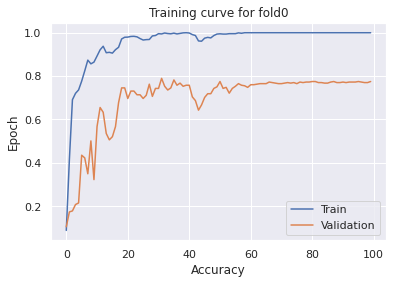

Epoch=0, Train loss=2.53209, Valid loss=2.34147, Train Accuracy=0.09524, Validation Accuracy=0.08293
Epoch=10, Train loss=0.31229, Valid loss=2.32552, Train Accuracy=0.89744, Validation Accuracy=0.68537
Epoch=20, Train loss=0.11477, Valid loss=1.40924, Train Accuracy=0.95849, Validation Accuracy=0.73415
Epoch=30, Train loss=0.03164, Valid loss=1.21673, Train Accuracy=0.99206, Validation Accuracy=0.76341
Epoch=40, Train loss=0.07920, Valid loss=1.72195, Train Accuracy=0.97497, Validation Accuracy=0.75366
Epoch=50, Train loss=0.00178, Valid loss=1.18719, Train Accuracy=0.99939, Validation Accuracy=0.79512
Epoch=60, Train loss=0.00007, Valid loss=1.21611, Train Accuracy=1.00000, Validation Accuracy=0.80488
Epoch=70, Train loss=0.00005, Valid loss=1.22377, Train Accuracy=1.00000, Validation Accuracy=0.80244
Epoch=80, Train loss=0.00004, Valid loss=1.21929, Train Accuracy=1.00000, Validation Accuracy=0.80244
Epoch=90, Train loss=0.00004, Valid loss=1.22376, Train Accuracy=1.00000, Validatio

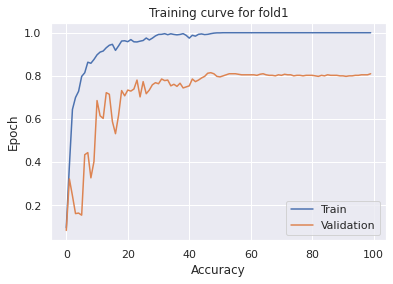

Epoch=0, Train loss=2.40031, Valid loss=2.31359, Train Accuracy=0.11416, Validation Accuracy=0.11220
Epoch=10, Train loss=0.36340, Valid loss=3.92203, Train Accuracy=0.88034, Validation Accuracy=0.56098
Epoch=20, Train loss=0.06296, Valid loss=1.28557, Train Accuracy=0.98291, Validation Accuracy=0.75854
Epoch=30, Train loss=0.04452, Valid loss=1.29928, Train Accuracy=0.98413, Validation Accuracy=0.73659
Epoch=40, Train loss=0.03302, Valid loss=1.36779, Train Accuracy=0.98779, Validation Accuracy=0.75122
Epoch=50, Train loss=0.02456, Valid loss=1.45622, Train Accuracy=0.99512, Validation Accuracy=0.76341
Epoch=60, Train loss=0.00017, Valid loss=1.06706, Train Accuracy=1.00000, Validation Accuracy=0.79024
Epoch=70, Train loss=0.00005, Valid loss=1.06644, Train Accuracy=1.00000, Validation Accuracy=0.78537
Epoch=80, Train loss=0.00004, Valid loss=1.06251, Train Accuracy=1.00000, Validation Accuracy=0.78537
Epoch=90, Train loss=0.00004, Valid loss=1.06550, Train Accuracy=1.00000, Validatio

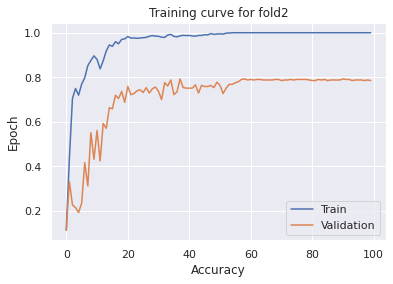

Epoch=0, Train loss=2.39817, Valid loss=2.33136, Train Accuracy=0.10134, Validation Accuracy=0.10488
Epoch=10, Train loss=0.25833, Valid loss=2.10188, Train Accuracy=0.91331, Validation Accuracy=0.65610
Epoch=20, Train loss=0.16640, Valid loss=1.80615, Train Accuracy=0.94811, Validation Accuracy=0.74146
Epoch=30, Train loss=0.07256, Valid loss=1.40492, Train Accuracy=0.97680, Validation Accuracy=0.76098
Epoch=40, Train loss=0.00081, Valid loss=1.15135, Train Accuracy=1.00000, Validation Accuracy=0.80244
Epoch=50, Train loss=0.00006, Valid loss=1.15938, Train Accuracy=1.00000, Validation Accuracy=0.80488
Epoch=60, Train loss=0.00003, Valid loss=1.15037, Train Accuracy=1.00000, Validation Accuracy=0.80000
Epoch=70, Train loss=0.00003, Valid loss=1.15296, Train Accuracy=1.00000, Validation Accuracy=0.80488
Epoch=80, Train loss=0.00002, Valid loss=1.14896, Train Accuracy=1.00000, Validation Accuracy=0.80244
Epoch=90, Train loss=0.00002, Valid loss=1.15412, Train Accuracy=1.00000, Validatio

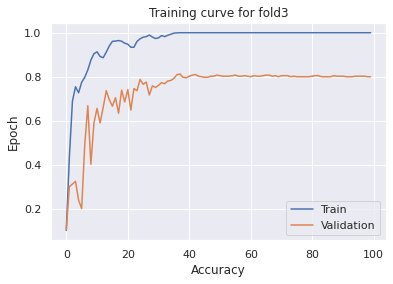

Epoch=0, Train loss=2.39255, Valid loss=2.31502, Train Accuracy=0.11409, Validation Accuracy=0.13447
Epoch=10, Train loss=0.29053, Valid loss=5.78275, Train Accuracy=0.90604, Validation Accuracy=0.46210
Epoch=20, Train loss=0.11454, Valid loss=2.07553, Train Accuracy=0.96461, Validation Accuracy=0.68460
Epoch=30, Train loss=0.03486, Valid loss=1.59347, Train Accuracy=0.99146, Validation Accuracy=0.73839
Epoch=40, Train loss=0.00613, Valid loss=1.58987, Train Accuracy=0.99756, Validation Accuracy=0.75061
Epoch=50, Train loss=0.00012, Valid loss=1.49190, Train Accuracy=1.00000, Validation Accuracy=0.75550
Epoch=60, Train loss=0.00004, Valid loss=1.45740, Train Accuracy=1.00000, Validation Accuracy=0.76528
Epoch=70, Train loss=0.00002, Valid loss=1.44813, Train Accuracy=1.00000, Validation Accuracy=0.76773
Epoch=80, Train loss=0.00002, Valid loss=1.45034, Train Accuracy=1.00000, Validation Accuracy=0.76773
Epoch=90, Train loss=0.00001, Valid loss=1.44372, Train Accuracy=1.00000, Validatio

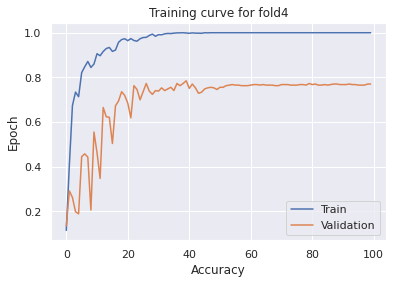

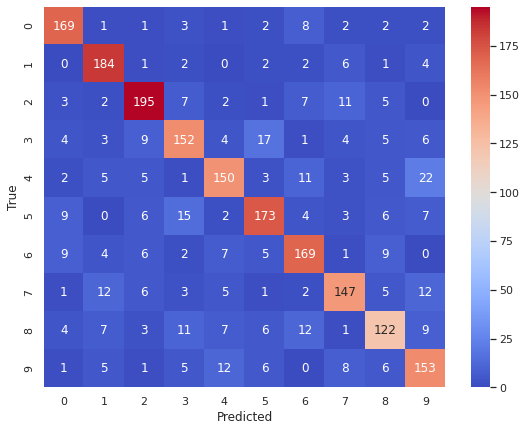

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86       191
         1.0       0.83      0.91      0.87       202
         2.0       0.84      0.84      0.84       233
         3.0       0.76      0.74      0.75       205
         4.0       0.79      0.72      0.76       207
         5.0       0.80      0.77      0.78       225
         6.0       0.78      0.80      0.79       212
         7.0       0.79      0.76      0.77       194
         8.0       0.73      0.67      0.70       182
         9.0       0.71      0.78      0.74       197

    accuracy                           0.79      2048
   macro avg       0.79      0.79      0.79      2048
weighted avg       0.79      0.79      0.79      2048

CV Accuracy Score=0.7880859375


In [7]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet18"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}-small"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [17]:
torch.cuda.empty_cache()
gc.collect()

56

#### ResNet34

Epoch=0, Train loss=2.67345, Valid loss=144.28108, Train Accuracy=0.18777, Validation Accuracy=0.09034
Epoch=10, Train loss=0.07624, Valid loss=0.28202, Train Accuracy=0.97474, Validation Accuracy=0.92540
Epoch=20, Train loss=0.05204, Valid loss=0.13827, Train Accuracy=0.98332, Validation Accuracy=0.96664
Epoch=30, Train loss=0.00697, Valid loss=0.10813, Train Accuracy=0.99788, Validation Accuracy=0.97482
Epoch=40, Train loss=0.01404, Valid loss=0.13891, Train Accuracy=0.99551, Validation Accuracy=0.97136
Epoch=50, Train loss=0.01219, Valid loss=0.10488, Train Accuracy=0.99622, Validation Accuracy=0.97923
Epoch=60, Train loss=0.00002, Valid loss=0.07495, Train Accuracy=1.00000, Validation Accuracy=0.98552
Epoch=70, Train loss=0.00001, Valid loss=0.07657, Train Accuracy=1.00000, Validation Accuracy=0.98615
Epoch=80, Train loss=0.00001, Valid loss=0.07698, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=90, Train loss=0.00001, Valid loss=0.07906, Train Accuracy=1.00000, Validat

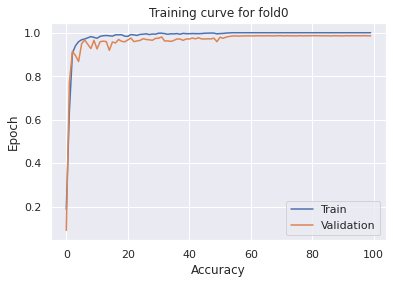

Epoch=0, Train loss=3.04400, Valid loss=2.14882, Train Accuracy=0.19690, Validation Accuracy=0.30469
Epoch=10, Train loss=0.92024, Valid loss=2476.44018, Train Accuracy=0.74660, Validation Accuracy=0.09097
Epoch=20, Train loss=0.07907, Valid loss=0.16119, Train Accuracy=0.97183, Validation Accuracy=0.94932
Epoch=30, Train loss=0.03985, Valid loss=0.09930, Train Accuracy=0.98662, Validation Accuracy=0.97104
Epoch=40, Train loss=0.01242, Valid loss=0.12876, Train Accuracy=0.99614, Validation Accuracy=0.96852
Epoch=50, Train loss=0.01379, Valid loss=0.12985, Train Accuracy=0.99512, Validation Accuracy=0.97325
Epoch=60, Train loss=0.00005, Valid loss=0.08008, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=70, Train loss=0.00004, Valid loss=0.07848, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.00002, Valid loss=0.08111, Train Accuracy=1.00000, Validation Accuracy=0.98426
Epoch=90, Train loss=0.00003, Valid loss=0.08702, Train Accuracy=1.00000, Valida

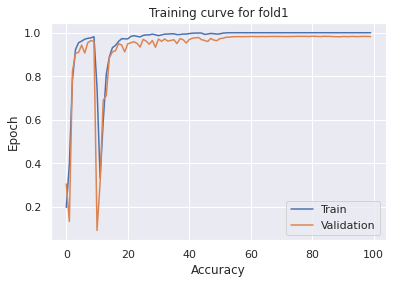

Epoch=0, Train loss=1.64829, Valid loss=1.94092, Train Accuracy=0.49583, Validation Accuracy=0.55069
Epoch=10, Train loss=0.04334, Valid loss=0.24457, Train Accuracy=0.98639, Validation Accuracy=0.94238
Epoch=20, Train loss=0.03014, Valid loss=0.14301, Train Accuracy=0.99016, Validation Accuracy=0.96379
Epoch=30, Train loss=0.02596, Valid loss=0.13547, Train Accuracy=0.99245, Validation Accuracy=0.96914
Epoch=40, Train loss=0.00886, Valid loss=0.11575, Train Accuracy=0.99725, Validation Accuracy=0.97450
Epoch=50, Train loss=0.00301, Valid loss=0.10127, Train Accuracy=0.99913, Validation Accuracy=0.98016
Epoch=60, Train loss=0.00092, Valid loss=0.08211, Train Accuracy=0.99976, Validation Accuracy=0.98174
Epoch=70, Train loss=0.00001, Valid loss=0.08165, Train Accuracy=1.00000, Validation Accuracy=0.98457
Epoch=80, Train loss=0.00001, Valid loss=0.08187, Train Accuracy=1.00000, Validation Accuracy=0.98426
Epoch=90, Train loss=0.00001, Valid loss=0.08185, Train Accuracy=1.00000, Validatio

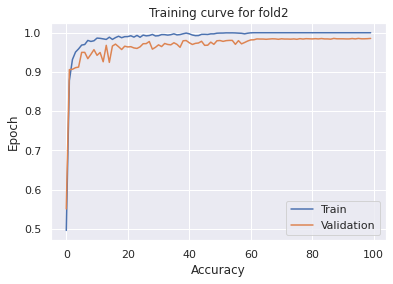

Epoch=0, Train loss=2.71140, Valid loss=318.91910, Train Accuracy=0.17904, Validation Accuracy=0.09852
Epoch=10, Train loss=0.04831, Valid loss=0.11422, Train Accuracy=0.98442, Validation Accuracy=0.96789
Epoch=20, Train loss=0.02963, Valid loss=0.12847, Train Accuracy=0.99142, Validation Accuracy=0.96506
Epoch=30, Train loss=0.02599, Valid loss=0.11936, Train Accuracy=0.99229, Validation Accuracy=0.97199
Epoch=40, Train loss=0.02763, Valid loss=0.10508, Train Accuracy=0.99064, Validation Accuracy=0.97041
Epoch=50, Train loss=0.00823, Valid loss=0.07105, Train Accuracy=0.99788, Validation Accuracy=0.98269
Epoch=60, Train loss=0.00003, Valid loss=0.05671, Train Accuracy=1.00000, Validation Accuracy=0.98741
Epoch=70, Train loss=0.00002, Valid loss=0.05600, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=80, Train loss=0.00002, Valid loss=0.05628, Train Accuracy=1.00000, Validation Accuracy=0.98772
Epoch=90, Train loss=0.00002, Valid loss=0.05651, Train Accuracy=1.00000, Validat

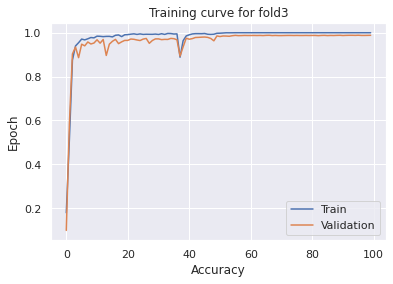

Epoch=0, Train loss=2.62454, Valid loss=64.18946, Train Accuracy=0.23420, Validation Accuracy=0.08908
Epoch=10, Train loss=0.04333, Valid loss=0.12113, Train Accuracy=0.98631, Validation Accuracy=0.96475
Epoch=20, Train loss=0.02227, Valid loss=0.10065, Train Accuracy=0.99245, Validation Accuracy=0.97262
Epoch=30, Train loss=0.02107, Valid loss=0.12164, Train Accuracy=0.99323, Validation Accuracy=0.97387
Epoch=40, Train loss=0.00539, Valid loss=0.08482, Train Accuracy=0.99803, Validation Accuracy=0.97954
Epoch=50, Train loss=0.00285, Valid loss=0.08880, Train Accuracy=0.99913, Validation Accuracy=0.97891
Epoch=60, Train loss=0.00247, Valid loss=0.07354, Train Accuracy=0.99921, Validation Accuracy=0.98363
Epoch=70, Train loss=0.00012, Valid loss=0.07143, Train Accuracy=1.00000, Validation Accuracy=0.98489
Epoch=80, Train loss=0.00004, Valid loss=0.06903, Train Accuracy=1.00000, Validation Accuracy=0.98521
Epoch=90, Train loss=0.00003, Valid loss=0.06863, Train Accuracy=1.00000, Validati

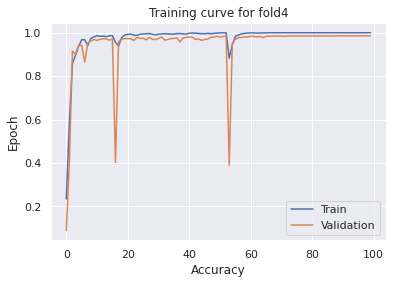

CV Accuracy Score=0.9855829765802065


In [11]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet34"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=False)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

#### ResNet50

Epoch=0, Train loss=7.26148, Valid loss=228.73491, Train Accuracy=0.10356, Validation Accuracy=0.12213
Epoch=10, Train loss=0.57719, Valid loss=0.26730, Train Accuracy=0.97710, Validation Accuracy=0.93925
Epoch=20, Train loss=0.52212, Valid loss=0.24488, Train Accuracy=0.99213, Validation Accuracy=0.94901
Epoch=30, Train loss=0.51631, Valid loss=0.20128, Train Accuracy=0.99418, Validation Accuracy=0.96443
Epoch=40, Train loss=0.50700, Valid loss=0.21512, Train Accuracy=0.99732, Validation Accuracy=0.96191
Epoch=50, Train loss=0.51159, Valid loss=0.18000, Train Accuracy=0.99591, Validation Accuracy=0.97041
Epoch=60, Train loss=0.50058, Valid loss=0.15004, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=70, Train loss=0.50046, Valid loss=0.14693, Train Accuracy=1.00000, Validation Accuracy=0.98363
Epoch=80, Train loss=0.50038, Valid loss=0.14636, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=90, Train loss=0.50036, Valid loss=0.14645, Train Accuracy=1.00000, Validat

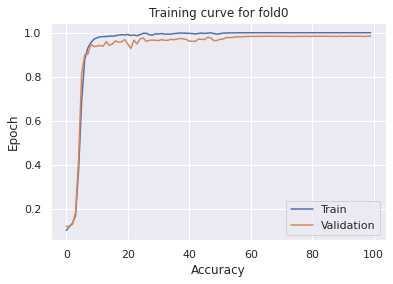

Epoch=0, Train loss=5.53529, Valid loss=316.29223, Train Accuracy=0.10065, Validation Accuracy=0.10482
Epoch=10, Train loss=0.55580, Valid loss=0.27708, Train Accuracy=0.97922, Validation Accuracy=0.94145
Epoch=20, Train loss=0.51709, Valid loss=0.18571, Train Accuracy=0.99481, Validation Accuracy=0.96789
Epoch=30, Train loss=0.51566, Valid loss=0.19303, Train Accuracy=0.99488, Validation Accuracy=0.96569
Epoch=40, Train loss=0.50613, Valid loss=0.19162, Train Accuracy=0.99764, Validation Accuracy=0.96884
Epoch=50, Train loss=0.50223, Valid loss=0.15351, Train Accuracy=0.99937, Validation Accuracy=0.98017
Epoch=60, Train loss=0.50042, Valid loss=0.14447, Train Accuracy=1.00000, Validation Accuracy=0.98269
Epoch=70, Train loss=0.50038, Valid loss=0.14407, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.50035, Valid loss=0.14258, Train Accuracy=1.00000, Validation Accuracy=0.98269
Epoch=90, Train loss=0.50034, Valid loss=0.14391, Train Accuracy=1.00000, Validat

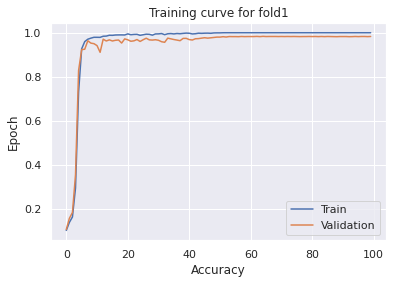

Epoch=0, Train loss=5.63020, Valid loss=1587.56788, Train Accuracy=0.10112, Validation Accuracy=0.11555
Epoch=10, Train loss=0.55842, Valid loss=0.25658, Train Accuracy=0.97805, Validation Accuracy=0.95025
Epoch=20, Train loss=0.53607, Valid loss=0.26105, Train Accuracy=0.98796, Validation Accuracy=0.94332
Epoch=30, Train loss=0.52085, Valid loss=0.20385, Train Accuracy=0.99323, Validation Accuracy=0.96946
Epoch=40, Train loss=0.50645, Valid loss=0.19722, Train Accuracy=0.99819, Validation Accuracy=0.96568
Epoch=50, Train loss=0.50704, Valid loss=0.14613, Train Accuracy=0.99811, Validation Accuracy=0.98111
Epoch=60, Train loss=0.50221, Valid loss=0.15869, Train Accuracy=0.99953, Validation Accuracy=0.98048
Epoch=70, Train loss=0.50041, Valid loss=0.15472, Train Accuracy=1.00000, Validation Accuracy=0.98237
Epoch=80, Train loss=0.50037, Valid loss=0.15447, Train Accuracy=1.00000, Validation Accuracy=0.98205
Epoch=90, Train loss=0.50036, Valid loss=0.15359, Train Accuracy=1.00000, Valida

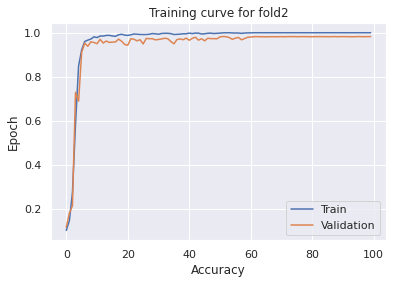

Epoch=0, Train loss=7.40592, Valid loss=1395.78667, Train Accuracy=0.10498, Validation Accuracy=0.08562
Epoch=10, Train loss=0.60092, Valid loss=0.20720, Train Accuracy=0.96648, Validation Accuracy=0.95751
Epoch=20, Train loss=0.52502, Valid loss=0.19150, Train Accuracy=0.99252, Validation Accuracy=0.96758
Epoch=30, Train loss=0.51869, Valid loss=0.18192, Train Accuracy=0.99426, Validation Accuracy=0.97199
Epoch=40, Train loss=0.51955, Valid loss=0.17810, Train Accuracy=0.99378, Validation Accuracy=0.97387
Epoch=50, Train loss=0.50648, Valid loss=0.18085, Train Accuracy=0.99835, Validation Accuracy=0.97230
Epoch=60, Train loss=0.50218, Valid loss=0.17415, Train Accuracy=0.99961, Validation Accuracy=0.97262
Epoch=70, Train loss=0.50049, Valid loss=0.13973, Train Accuracy=1.00000, Validation Accuracy=0.98363
Epoch=80, Train loss=0.50045, Valid loss=0.13996, Train Accuracy=1.00000, Validation Accuracy=0.98395
Epoch=90, Train loss=0.50041, Valid loss=0.14065, Train Accuracy=1.00000, Valida

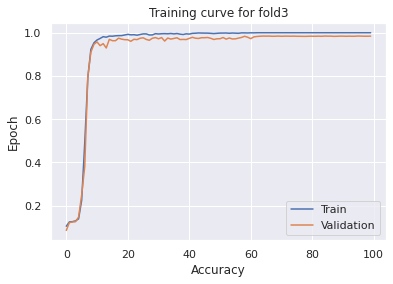

Epoch=0, Train loss=6.27909, Valid loss=188211.92935, Train Accuracy=0.10356, Validation Accuracy=0.10041
Epoch=10, Train loss=0.57196, Valid loss=0.22952, Train Accuracy=0.97505, Validation Accuracy=0.95373
Epoch=20, Train loss=0.53134, Valid loss=0.19131, Train Accuracy=0.98993, Validation Accuracy=0.97136
Epoch=30, Train loss=0.51821, Valid loss=0.16021, Train Accuracy=0.99426, Validation Accuracy=0.97545
Epoch=40, Train loss=0.51290, Valid loss=0.16227, Train Accuracy=0.99567, Validation Accuracy=0.97923
Epoch=50, Train loss=0.50183, Valid loss=0.14484, Train Accuracy=0.99961, Validation Accuracy=0.98332
Epoch=60, Train loss=0.51065, Valid loss=0.16755, Train Accuracy=0.99662, Validation Accuracy=0.97545
Epoch=70, Train loss=0.50049, Valid loss=0.13405, Train Accuracy=1.00000, Validation Accuracy=0.98647
Epoch=80, Train loss=0.50043, Valid loss=0.13474, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=90, Train loss=0.50039, Valid loss=0.13289, Train Accuracy=1.00000, Vali

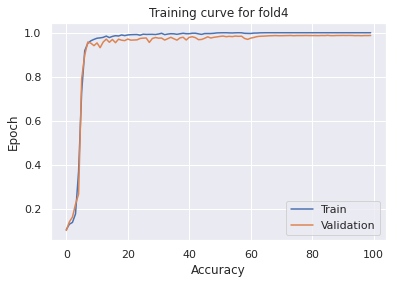

CV Accuracy Score=0.9844497607655502


In [12]:
# Training Parameters
lr = 0.1
epochs = 100
model_name = "resnet50"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

# k-fold
oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [14]:
gc.collect()
torch.cuda.empty_cache()

### EfficientNet

#### EfficientNet-B0

##### Vanilla

Epoch=0, Train loss=2.34621, Valid loss=2.30391, Train Accuracy=0.08847, Validation Accuracy=0.08313
Epoch=10, Train loss=0.73372, Valid loss=2.23790, Train Accuracy=0.92373, Validation Accuracy=0.29340
Epoch=20, Train loss=0.62169, Valid loss=1.75522, Train Accuracy=0.96095, Validation Accuracy=0.48411
Epoch=30, Train loss=0.55619, Valid loss=1.38192, Train Accuracy=0.98231, Validation Accuracy=0.61858
Epoch=40, Train loss=0.51733, Valid loss=1.36576, Train Accuracy=0.99451, Validation Accuracy=0.63814
Epoch=50, Train loss=0.50947, Valid loss=1.38063, Train Accuracy=0.99878, Validation Accuracy=0.65770
Epoch=60, Train loss=0.50353, Valid loss=1.32338, Train Accuracy=1.00000, Validation Accuracy=0.68215
Fold=0, Validation Accuracy=0.6821515892420538


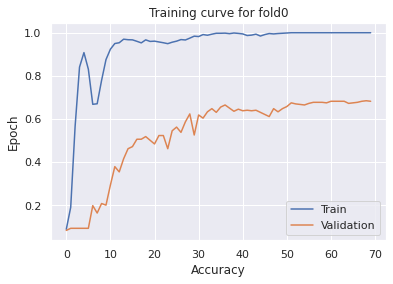

Epoch=0, Train loss=2.34336, Valid loss=2.30093, Train Accuracy=0.10195, Validation Accuracy=0.10244
Epoch=10, Train loss=0.76254, Valid loss=2.38572, Train Accuracy=0.91148, Validation Accuracy=0.31951
Epoch=20, Train loss=0.61334, Valid loss=1.59466, Train Accuracy=0.95910, Validation Accuracy=0.54146
Epoch=30, Train loss=0.53903, Valid loss=1.31207, Train Accuracy=0.99084, Validation Accuracy=0.65366
Epoch=40, Train loss=0.51472, Valid loss=1.15966, Train Accuracy=0.99634, Validation Accuracy=0.67805
Epoch=50, Train loss=0.50416, Valid loss=1.09472, Train Accuracy=1.00000, Validation Accuracy=0.71707
Epoch=60, Train loss=0.50376, Valid loss=1.08630, Train Accuracy=1.00000, Validation Accuracy=0.72927
Fold=1, Validation Accuracy=0.7268292682926829


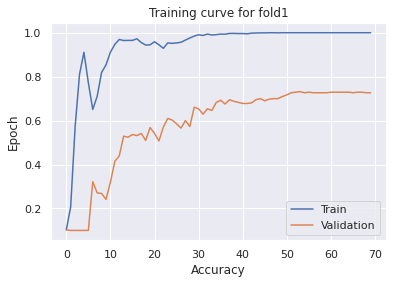

Epoch=0, Train loss=2.34718, Valid loss=2.30322, Train Accuracy=0.08242, Validation Accuracy=0.12195
Epoch=10, Train loss=0.76999, Valid loss=5.50785, Train Accuracy=0.90720, Validation Accuracy=0.19024
Epoch=20, Train loss=0.66085, Valid loss=1.73595, Train Accuracy=0.94139, Validation Accuracy=0.51463
Epoch=30, Train loss=0.54121, Valid loss=1.38454, Train Accuracy=0.98962, Validation Accuracy=0.60488
Epoch=40, Train loss=0.51256, Valid loss=1.44877, Train Accuracy=0.99756, Validation Accuracy=0.61707
Epoch=50, Train loss=0.50369, Valid loss=1.47214, Train Accuracy=1.00000, Validation Accuracy=0.61220
Epoch=60, Train loss=0.50335, Valid loss=1.45239, Train Accuracy=1.00000, Validation Accuracy=0.61220
Fold=2, Validation Accuracy=0.6121951219512195


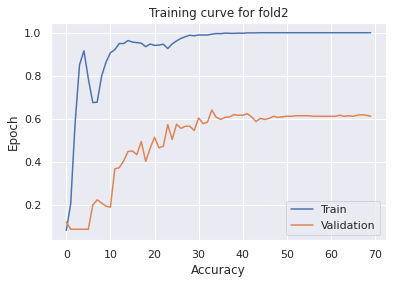

Epoch=0, Train loss=2.33960, Valid loss=2.30294, Train Accuracy=0.09219, Validation Accuracy=0.11951
Epoch=10, Train loss=0.79555, Valid loss=3.49435, Train Accuracy=0.90171, Validation Accuracy=0.17805
Epoch=20, Train loss=0.62844, Valid loss=1.78540, Train Accuracy=0.95604, Validation Accuracy=0.48049
Epoch=30, Train loss=0.55818, Valid loss=1.32252, Train Accuracy=0.97863, Validation Accuracy=0.64390
Epoch=40, Train loss=0.50614, Valid loss=1.34841, Train Accuracy=1.00000, Validation Accuracy=0.62683
Epoch=50, Train loss=0.50408, Valid loss=1.32312, Train Accuracy=1.00000, Validation Accuracy=0.65610
Epoch=60, Train loss=0.50318, Valid loss=1.31752, Train Accuracy=1.00000, Validation Accuracy=0.66098
Fold=3, Validation Accuracy=0.6609756097560976


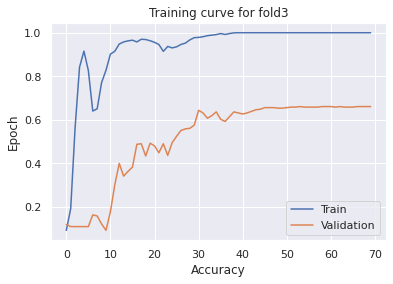

Epoch=0, Train loss=2.34879, Valid loss=2.30261, Train Accuracy=0.10372, Validation Accuracy=0.12225
Epoch=10, Train loss=0.74660, Valid loss=2.18016, Train Accuracy=0.91031, Validation Accuracy=0.31051
Epoch=20, Train loss=0.68013, Valid loss=1.75822, Train Accuracy=0.92862, Validation Accuracy=0.52078
Epoch=30, Train loss=0.55160, Valid loss=1.32845, Train Accuracy=0.98292, Validation Accuracy=0.62836
Epoch=40, Train loss=0.54241, Valid loss=1.38630, Train Accuracy=0.98658, Validation Accuracy=0.62347
Epoch=50, Train loss=0.50467, Valid loss=1.19866, Train Accuracy=1.00000, Validation Accuracy=0.68215
Epoch=60, Train loss=0.50366, Valid loss=1.18103, Train Accuracy=1.00000, Validation Accuracy=0.68460
Fold=4, Validation Accuracy=0.6894865525672371


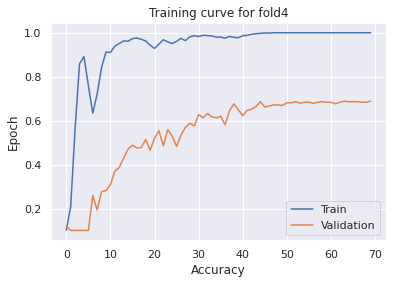

CV Accuracy Score=0.67431640625


In [12]:
lr = 0.03
epochs = 70
model_name = "efficientnet-b0"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}-small"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [10]:
gc.collect()
torch.cuda.empty_cache()

##### SWA

../src/radam.py:84: UserWarning: This overload of addcdiv_ is deprecated:
	addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcdiv_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  p_data_fp32.addcdiv_(-step_size, exp_avg, denom)


Epoch=0, Accuracy=0.7784073024866226
Epoch=10, Accuracy=0.9483789738747246
Epoch=20, Accuracy=0.9631728045325779
Epoch=30, Accuracy=0.9628580421781555
Epoch=40, Accuracy=0.9773371104815864
Epoch=50, Accuracy=0.9723009128108279
Epoch=60, Accuracy=0.9719861504564055
Epoch=70, Accuracy=0.9723009128108279
Epoch=80, Accuracy=0.9571923197985521
Epoch=90, Accuracy=0.9833175952156122
Epoch=100, Accuracy=0.9842618822788795
Epoch=110, Accuracy=0.983947119924457
Epoch=120, Accuracy=0.9845766446333019
Epoch=130, Accuracy=0.9848914069877243
Epoch=140, Accuracy=0.9848914069877243
Epoch=150, Accuracy=0.9845766446333019
Epoch=160, Accuracy=0.9845766446333019
Fold=0, Validation Accuracy=0.9845766446333019


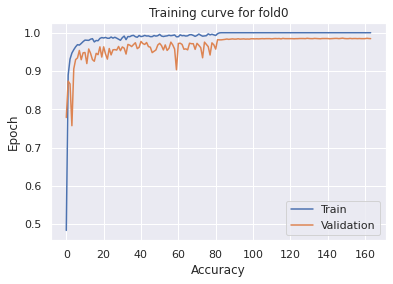

UnboundLocalError: local variable 'model' referenced before assignment

In [8]:
lr = 0.03
epochs = 164
model_name = "efficientnet-b0"
optim_name = "radam"
checkpoint = f"./checkpoints/swa-efficientnet-b0-radam{lr}"

oof, targs = run(model, model_name, optimizer, scheduler, epochs, lr, checkpoint, swa=True, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

#### EfficientNet-B1

Epoch=0, Train loss=2.05949, Valid loss=2.31869, Train Accuracy=0.27607, Validation Accuracy=0.08908
Epoch=10, Train loss=0.10645, Valid loss=4.56958, Train Accuracy=0.97017, Validation Accuracy=0.80107
Epoch=20, Train loss=0.08573, Valid loss=0.28340, Train Accuracy=0.97033, Validation Accuracy=0.93359
Epoch=30, Train loss=0.03278, Valid loss=0.54056, Train Accuracy=0.98906, Validation Accuracy=0.90400
Epoch=40, Train loss=0.01194, Valid loss=0.12083, Train Accuracy=0.99638, Validation Accuracy=0.97450
Epoch=50, Train loss=0.00942, Valid loss=0.10354, Train Accuracy=0.99693, Validation Accuracy=0.97828
Epoch=60, Train loss=0.00900, Valid loss=0.13365, Train Accuracy=0.99748, Validation Accuracy=0.97073
Epoch=70, Train loss=0.00028, Valid loss=0.08048, Train Accuracy=0.99992, Validation Accuracy=0.98206
Epoch=80, Train loss=0.00017, Valid loss=0.08441, Train Accuracy=1.00000, Validation Accuracy=0.98237
Epoch=90, Train loss=0.00023, Valid loss=0.08063, Train Accuracy=0.99992, Validatio

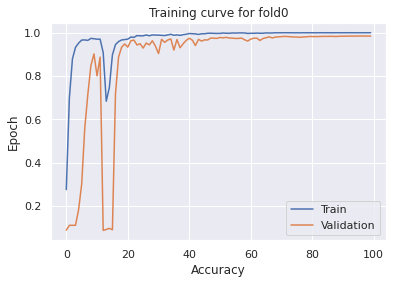

Epoch=0, Train loss=2.08967, Valid loss=2.31685, Train Accuracy=0.27095, Validation Accuracy=0.10733
Epoch=10, Train loss=0.10647, Valid loss=28.21428, Train Accuracy=0.96876, Validation Accuracy=0.83129
Epoch=20, Train loss=0.03936, Valid loss=0.15458, Train Accuracy=0.98764, Validation Accuracy=0.96789
Epoch=30, Train loss=0.05657, Valid loss=0.16156, Train Accuracy=0.98229, Validation Accuracy=0.96632
Epoch=40, Train loss=0.02371, Valid loss=0.24115, Train Accuracy=0.99292, Validation Accuracy=0.95121
Epoch=50, Train loss=0.00586, Valid loss=0.08809, Train Accuracy=0.99795, Validation Accuracy=0.97860
Epoch=60, Train loss=0.00460, Valid loss=0.10233, Train Accuracy=0.99835, Validation Accuracy=0.97576
Epoch=70, Train loss=0.00144, Valid loss=0.07929, Train Accuracy=0.99976, Validation Accuracy=0.98237
Epoch=80, Train loss=0.00036, Valid loss=0.07355, Train Accuracy=0.99992, Validation Accuracy=0.98458
Epoch=90, Train loss=0.00005, Valid loss=0.07048, Train Accuracy=1.00000, Validati

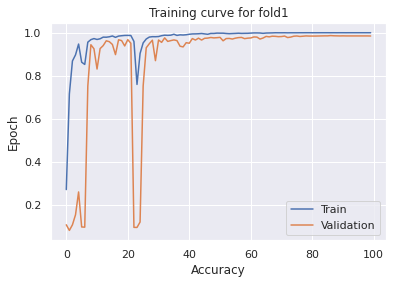

Epoch=0, Train loss=1.97368, Valid loss=2.33702, Train Accuracy=0.30556, Validation Accuracy=0.07746
Epoch=10, Train loss=0.06149, Valid loss=0.52293, Train Accuracy=0.98009, Validation Accuracy=0.92034
Epoch=20, Train loss=1.17928, Valid loss=15.18341, Train Accuracy=0.56020, Validation Accuracy=0.26196
Epoch=30, Train loss=0.06845, Valid loss=0.21657, Train Accuracy=0.97726, Validation Accuracy=0.94616
Epoch=40, Train loss=0.03351, Valid loss=0.14105, Train Accuracy=0.98914, Validation Accuracy=0.96788
Epoch=50, Train loss=0.02148, Valid loss=0.15759, Train Accuracy=0.99300, Validation Accuracy=0.96505
Epoch=60, Train loss=0.00998, Valid loss=0.17597, Train Accuracy=0.99638, Validation Accuracy=0.96379
Epoch=70, Train loss=0.00121, Valid loss=0.09265, Train Accuracy=0.99961, Validation Accuracy=0.97922
Epoch=80, Train loss=0.00086, Valid loss=0.10192, Train Accuracy=0.99961, Validation Accuracy=0.97985
Epoch=90, Train loss=0.00014, Valid loss=0.09892, Train Accuracy=1.00000, Validati

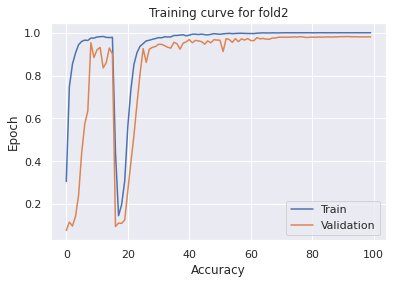

Epoch=0, Train loss=1.99915, Valid loss=2.33480, Train Accuracy=0.29409, Validation Accuracy=0.09632
Epoch=10, Train loss=0.13575, Valid loss=0.53783, Train Accuracy=0.95506, Validation Accuracy=0.88196
Epoch=20, Train loss=0.04158, Valid loss=0.29805, Train Accuracy=0.98536, Validation Accuracy=0.94208
Epoch=30, Train loss=0.03372, Valid loss=0.24830, Train Accuracy=0.98859, Validation Accuracy=0.95404
Epoch=40, Train loss=0.02140, Valid loss=0.13316, Train Accuracy=0.99245, Validation Accuracy=0.97230
Epoch=50, Train loss=0.00781, Valid loss=0.12400, Train Accuracy=0.99764, Validation Accuracy=0.97482
Epoch=60, Train loss=0.00598, Valid loss=0.10895, Train Accuracy=0.99827, Validation Accuracy=0.97639
Epoch=70, Train loss=0.00031, Valid loss=0.07185, Train Accuracy=1.00000, Validation Accuracy=0.98615
Epoch=80, Train loss=0.00035, Valid loss=0.08557, Train Accuracy=0.99992, Validation Accuracy=0.98300
Epoch=90, Train loss=0.00015, Valid loss=0.07325, Train Accuracy=0.99992, Validatio

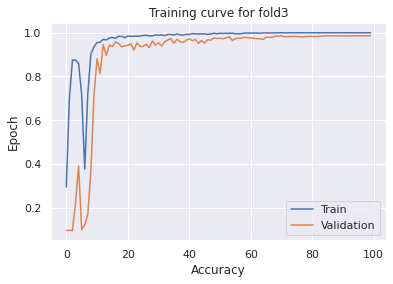

Epoch=0, Train loss=1.97647, Valid loss=2.33676, Train Accuracy=0.29740, Validation Accuracy=0.09128
Epoch=10, Train loss=0.07780, Valid loss=0.37589, Train Accuracy=0.97600, Validation Accuracy=0.93736
Epoch=20, Train loss=0.90351, Valid loss=6.62962, Train Accuracy=0.70229, Validation Accuracy=0.43846
Epoch=30, Train loss=0.16545, Valid loss=0.55850, Train Accuracy=0.94531, Validation Accuracy=0.87504
Epoch=40, Train loss=0.03773, Valid loss=0.18421, Train Accuracy=0.98843, Validation Accuracy=0.95562
Epoch=50, Train loss=0.02074, Valid loss=0.18820, Train Accuracy=0.99323, Validation Accuracy=0.95940
Epoch=60, Train loss=0.00513, Valid loss=0.12042, Train Accuracy=0.99788, Validation Accuracy=0.97702
Epoch=70, Train loss=0.00455, Valid loss=0.14944, Train Accuracy=0.99890, Validation Accuracy=0.96852
Epoch=80, Train loss=0.00091, Valid loss=0.13805, Train Accuracy=0.99961, Validation Accuracy=0.97671
Epoch=90, Train loss=0.00112, Valid loss=0.13429, Train Accuracy=0.99976, Validatio

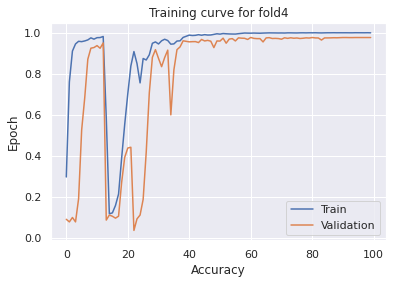

CV Accuracy Score=0.9826240241752707


In [32]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b1"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [34]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B2

Epoch=0, Train loss=2.36912, Valid loss=2.30278, Train Accuracy=0.10231, Validation Accuracy=0.10230
Epoch=10, Train loss=0.60130, Valid loss=0.43726, Train Accuracy=0.96632, Validation Accuracy=0.88606
Epoch=20, Train loss=0.53419, Valid loss=0.24390, Train Accuracy=0.98875, Validation Accuracy=0.94743
Epoch=30, Train loss=0.52961, Valid loss=0.23757, Train Accuracy=0.99197, Validation Accuracy=0.95153
Epoch=40, Train loss=0.52072, Valid loss=0.18452, Train Accuracy=0.99386, Validation Accuracy=0.96884
Epoch=50, Train loss=0.50797, Valid loss=0.18440, Train Accuracy=0.99795, Validation Accuracy=0.96884
Epoch=60, Train loss=0.50585, Valid loss=0.15981, Train Accuracy=0.99866, Validation Accuracy=0.97702
Epoch=70, Train loss=0.50220, Valid loss=0.16516, Train Accuracy=0.99992, Validation Accuracy=0.98017
Epoch=80, Train loss=0.50204, Valid loss=0.16189, Train Accuracy=0.99984, Validation Accuracy=0.98174
Epoch=90, Train loss=0.50162, Valid loss=0.15551, Train Accuracy=1.00000, Validatio

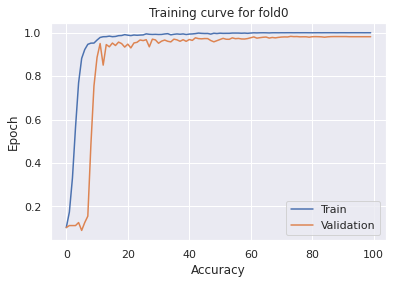

Epoch=0, Train loss=2.38152, Valid loss=2.30297, Train Accuracy=0.09758, Validation Accuracy=0.11048
Epoch=10, Train loss=0.58660, Valid loss=0.61926, Train Accuracy=0.97222, Validation Accuracy=0.84545
Epoch=20, Train loss=0.53722, Valid loss=0.29103, Train Accuracy=0.98883, Validation Accuracy=0.93579


KeyboardInterrupt: 

In [13]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b2"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [14]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B3

In [38]:
lr = 0.03
epochs = 100
model_name = "efficientnet-b3"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

RuntimeError: running_mean should contain 32 elements not 40

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B4

Epoch=0, Train loss=2.18753, Valid loss=2.30316, Train Accuracy=0.21783, Validation Accuracy=0.09726
Epoch=10, Train loss=0.08496, Valid loss=0.21587, Train Accuracy=0.97553, Validation Accuracy=0.94995
Epoch=20, Train loss=0.04487, Valid loss=0.20196, Train Accuracy=0.98717, Validation Accuracy=0.96003
Epoch=30, Train loss=0.01561, Valid loss=0.15455, Train Accuracy=0.99559, Validation Accuracy=0.96695
Epoch=40, Train loss=0.02628, Valid loss=0.14747, Train Accuracy=0.99197, Validation Accuracy=0.96947
Epoch=50, Train loss=0.01306, Valid loss=0.07946, Train Accuracy=0.99638, Validation Accuracy=0.98048
Epoch=60, Train loss=0.01338, Valid loss=0.10168, Train Accuracy=0.99709, Validation Accuracy=0.97734
Epoch=70, Train loss=0.00017, Valid loss=0.07631, Train Accuracy=1.00000, Validation Accuracy=0.98300
Epoch=80, Train loss=0.00016, Valid loss=0.08743, Train Accuracy=0.99992, Validation Accuracy=0.98332
Epoch=90, Train loss=0.00035, Valid loss=0.08704, Train Accuracy=0.99984, Validatio

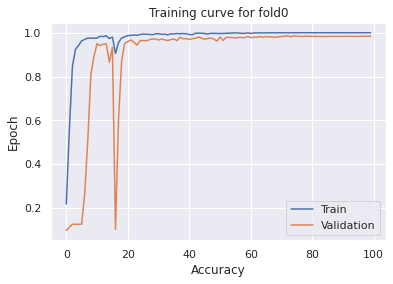

Epoch=0, Train loss=2.26633, Valid loss=2.30193, Train Accuracy=0.18439, Validation Accuracy=0.12024
Epoch=10, Train loss=0.05977, Valid loss=0.22060, Train Accuracy=0.98111, Validation Accuracy=0.94303
Epoch=20, Train loss=0.03719, Valid loss=0.17753, Train Accuracy=0.98843, Validation Accuracy=0.95814
Epoch=30, Train loss=0.02867, Valid loss=0.28678, Train Accuracy=0.99150, Validation Accuracy=0.94492
Epoch=40, Train loss=0.02519, Valid loss=0.27910, Train Accuracy=0.99268, Validation Accuracy=0.93296
Epoch=50, Train loss=0.00440, Valid loss=0.10226, Train Accuracy=0.99835, Validation Accuracy=0.97671
Epoch=60, Train loss=0.00269, Valid loss=0.09170, Train Accuracy=0.99898, Validation Accuracy=0.98269
Epoch=70, Train loss=0.00005, Valid loss=0.06236, Train Accuracy=1.00000, Validation Accuracy=0.98709
Epoch=80, Train loss=0.00064, Valid loss=0.06058, Train Accuracy=0.99984, Validation Accuracy=0.98772
Epoch=90, Train loss=0.00002, Valid loss=0.06311, Train Accuracy=1.00000, Validatio

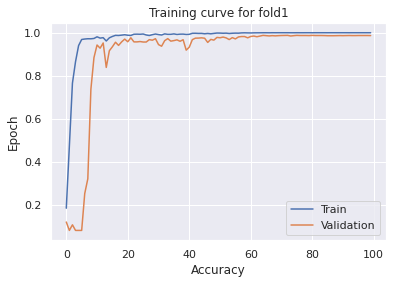

Epoch=0, Train loss=2.16421, Valid loss=2.30604, Train Accuracy=0.23056, Validation Accuracy=0.10044
Epoch=10, Train loss=0.06675, Valid loss=0.25456, Train Accuracy=0.97970, Validation Accuracy=0.93734
Epoch=20, Train loss=0.15721, Valid loss=243.51960, Train Accuracy=0.95357, Validation Accuracy=0.64610
Epoch=30, Train loss=0.02607, Valid loss=0.28007, Train Accuracy=0.99252, Validation Accuracy=0.94836
Epoch=40, Train loss=0.03687, Valid loss=0.25731, Train Accuracy=0.99032, Validation Accuracy=0.94868
Epoch=50, Train loss=0.00252, Valid loss=0.08654, Train Accuracy=0.99937, Validation Accuracy=0.98300
Epoch=60, Train loss=0.00426, Valid loss=0.09666, Train Accuracy=0.99906, Validation Accuracy=0.98142
Epoch=70, Train loss=0.00008, Valid loss=0.08286, Train Accuracy=1.00000, Validation Accuracy=0.98426
Epoch=80, Train loss=0.00032, Valid loss=0.08155, Train Accuracy=0.99976, Validation Accuracy=0.98583
Epoch=90, Train loss=0.00008, Valid loss=0.08233, Train Accuracy=1.00000, Validat

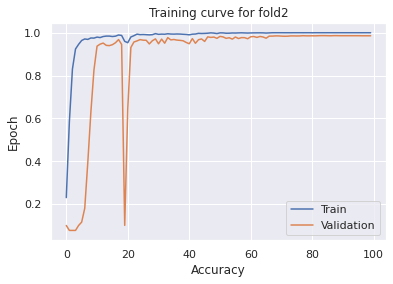

Epoch=0, Train loss=2.25806, Valid loss=2.30292, Train Accuracy=0.19769, Validation Accuracy=0.10419
Epoch=10, Train loss=0.06373, Valid loss=0.26284, Train Accuracy=0.98080, Validation Accuracy=0.93642
Epoch=20, Train loss=0.04971, Valid loss=0.25642, Train Accuracy=0.98536, Validation Accuracy=0.95782
Epoch=30, Train loss=0.02255, Valid loss=0.13554, Train Accuracy=0.99339, Validation Accuracy=0.97293
Epoch=40, Train loss=0.02371, Valid loss=0.09597, Train Accuracy=0.99315, Validation Accuracy=0.97702
Epoch=50, Train loss=0.00514, Valid loss=0.10024, Train Accuracy=0.99780, Validation Accuracy=0.97828
Epoch=60, Train loss=0.00214, Valid loss=0.07471, Train Accuracy=0.99937, Validation Accuracy=0.98143
Epoch=70, Train loss=0.00071, Valid loss=0.08417, Train Accuracy=0.99976, Validation Accuracy=0.98143
Epoch=80, Train loss=0.00020, Valid loss=0.08777, Train Accuracy=1.00000, Validation Accuracy=0.98363
Epoch=90, Train loss=0.00017, Valid loss=0.08317, Train Accuracy=0.99992, Validatio

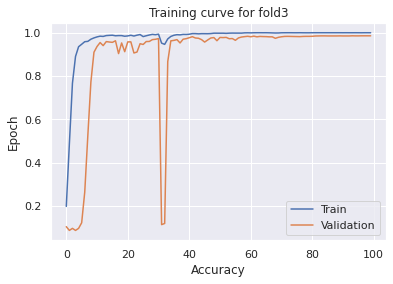

Epoch=0, Train loss=2.25563, Valid loss=2.30182, Train Accuracy=0.19871, Validation Accuracy=0.10009
Epoch=10, Train loss=0.05494, Valid loss=0.23547, Train Accuracy=0.98269, Validation Accuracy=0.93138
Epoch=20, Train loss=0.03416, Valid loss=0.26956, Train Accuracy=0.98820, Validation Accuracy=0.95373
Epoch=30, Train loss=2.95383, Valid loss=33132099088.92162, Train Accuracy=0.10703, Validation Accuracy=0.07869
Epoch=40, Train loss=2.31521, Valid loss=2.29818, Train Accuracy=0.13434, Validation Accuracy=0.14353
Epoch=50, Train loss=1.57596, Valid loss=2.62103, Train Accuracy=0.42772, Validation Accuracy=0.18414
Epoch=60, Train loss=0.27333, Valid loss=0.30922, Train Accuracy=0.91131, Validation Accuracy=0.90777
Epoch=70, Train loss=0.07538, Valid loss=0.14123, Train Accuracy=0.97442, Validation Accuracy=0.95404
Epoch=80, Train loss=0.03604, Valid loss=0.12819, Train Accuracy=0.98867, Validation Accuracy=0.95940
Epoch=90, Train loss=0.02435, Valid loss=0.11342, Train Accuracy=0.99245,

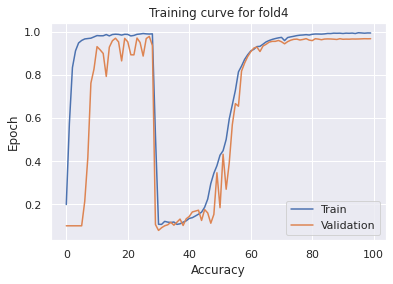

CV Accuracy Score=0.9821203727020902


In [17]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b4"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [16]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B5

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b5"
optim_name = "adam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
gc.collect()
torch.cuda.empty_cache()

#### EfficientNet-B6

Epoch=0, Train loss=2.84979, Valid loss=2.39355, Train Accuracy=0.11309, Validation Accuracy=0.11143
Epoch=10, Train loss=2.79945, Valid loss=204860055.81114, Train Accuracy=0.10781, Validation Accuracy=0.09223
Epoch=20, Train loss=2.54945, Valid loss=3.18550, Train Accuracy=0.11136, Validation Accuracy=0.10891
Epoch=30, Train loss=2.43432, Valid loss=2.43243, Train Accuracy=0.10884, Validation Accuracy=0.12622
Epoch=40, Train loss=2.37872, Valid loss=2.30288, Train Accuracy=0.10695, Validation Accuracy=0.09726
Epoch=50, Train loss=2.33882, Valid loss=4041.22025, Train Accuracy=0.11230, Validation Accuracy=0.12528
Epoch=60, Train loss=2.12622, Valid loss=2.26776, Train Accuracy=0.21886, Validation Accuracy=0.11300
Epoch=70, Train loss=0.95345, Valid loss=1.50221, Train Accuracy=0.82222, Validation Accuracy=0.49953
Epoch=80, Train loss=0.58645, Valid loss=0.41596, Train Accuracy=0.97372, Validation Accuracy=0.94429
Epoch=90, Train loss=0.55481, Valid loss=0.39710, Train Accuracy=0.98497

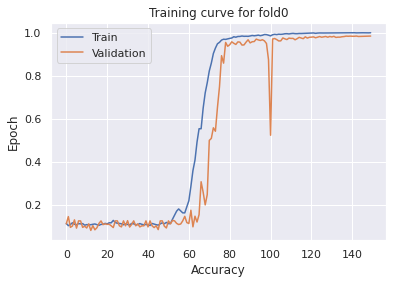

Epoch=0, Train loss=2.96091, Valid loss=2.40653, Train Accuracy=0.10695, Validation Accuracy=0.09726
Epoch=10, Train loss=2.77230, Valid loss=2.31292, Train Accuracy=0.10742, Validation Accuracy=0.10733
Epoch=20, Train loss=2.47133, Valid loss=2.30376, Train Accuracy=0.10805, Validation Accuracy=0.12024
Epoch=30, Train loss=2.35580, Valid loss=2.31408, Train Accuracy=0.11427, Validation Accuracy=0.11048
Epoch=40, Train loss=2.36221, Valid loss=77.49363, Train Accuracy=0.11348, Validation Accuracy=0.09097
Epoch=50, Train loss=2.35111, Valid loss=2.51919, Train Accuracy=0.10994, Validation Accuracy=0.12087
Epoch=60, Train loss=2.31321, Valid loss=2.29204, Train Accuracy=0.12828, Validation Accuracy=0.12653
Epoch=70, Train loss=2.30743, Valid loss=2.30155, Train Accuracy=0.12056, Validation Accuracy=0.12024
Epoch=80, Train loss=1.39150, Valid loss=1.94147, Train Accuracy=0.58653, Validation Accuracy=0.33522
Epoch=90, Train loss=0.62373, Valid loss=0.56769, Train Accuracy=0.95876, Validati

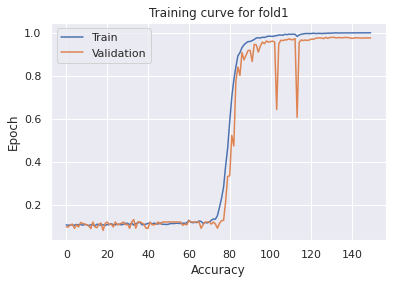

Epoch=0, Train loss=2.98833, Valid loss=15679.28951, Train Accuracy=0.10773, Validation Accuracy=0.07620
Epoch=10, Train loss=2.74600, Valid loss=543114.90019, Train Accuracy=0.10875, Validation Accuracy=0.11178
Epoch=20, Train loss=2.53399, Valid loss=2.31319, Train Accuracy=0.10867, Validation Accuracy=0.09320
Epoch=30, Train loss=2.34735, Valid loss=2.30158, Train Accuracy=0.14243, Validation Accuracy=0.11304
Epoch=40, Train loss=2.27072, Valid loss=2.27974, Train Accuracy=0.16029, Validation Accuracy=0.10044
Epoch=50, Train loss=1.71421, Valid loss=1.99436, Train Accuracy=0.45947, Validation Accuracy=0.27865
Epoch=60, Train loss=0.68625, Valid loss=1.00388, Train Accuracy=0.93335, Validation Accuracy=0.75693
Epoch=70, Train loss=0.57747, Valid loss=0.38254, Train Accuracy=0.97498, Validation Accuracy=0.95340
Epoch=80, Train loss=0.55077, Valid loss=0.34102, Train Accuracy=0.98450, Validation Accuracy=0.95781
Epoch=90, Train loss=0.53423, Valid loss=0.26998, Train Accuracy=0.98898, 

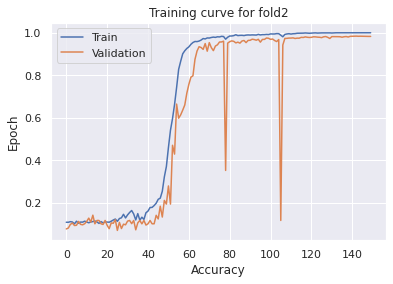

Epoch=0, Train loss=2.78228, Valid loss=2.35292, Train Accuracy=0.11222, Validation Accuracy=0.09128
Epoch=10, Train loss=2.78885, Valid loss=3252.87294, Train Accuracy=0.10797, Validation Accuracy=0.11363
Epoch=20, Train loss=2.58531, Valid loss=2.32208, Train Accuracy=0.10687, Validation Accuracy=0.09632
Epoch=30, Train loss=2.45168, Valid loss=16113.65228, Train Accuracy=0.10915, Validation Accuracy=0.10985
Epoch=40, Train loss=2.36990, Valid loss=2.31309, Train Accuracy=0.11529, Validation Accuracy=0.09128
Epoch=50, Train loss=2.32618, Valid loss=2.33440, Train Accuracy=0.13567, Validation Accuracy=0.10230
Epoch=60, Train loss=2.10999, Valid loss=2.14516, Train Accuracy=0.25506, Validation Accuracy=0.18540
Epoch=70, Train loss=1.58566, Valid loss=1.70573, Train Accuracy=0.52388, Validation Accuracy=0.44539
Epoch=80, Train loss=1.07531, Valid loss=1.06136, Train Accuracy=0.76178, Validation Accuracy=0.71955
Epoch=90, Train loss=0.80908, Valid loss=0.60482, Train Accuracy=0.87204, Va

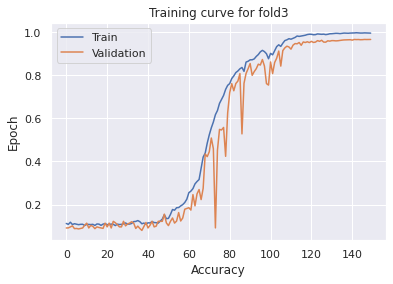

Epoch=0, Train loss=2.95181, Valid loss=2.32406, Train Accuracy=0.11238, Validation Accuracy=0.13157
Epoch=10, Train loss=2.74998, Valid loss=2.31589, Train Accuracy=0.10490, Validation Accuracy=0.09034
Epoch=20, Train loss=2.53991, Valid loss=2.30054, Train Accuracy=0.11230, Validation Accuracy=0.10607
Epoch=30, Train loss=2.40836, Valid loss=3.52941, Train Accuracy=0.10412, Validation Accuracy=0.09600
Epoch=40, Train loss=2.30747, Valid loss=2.29540, Train Accuracy=0.16156, Validation Accuracy=0.10607
Epoch=50, Train loss=2.22698, Valid loss=2.23526, Train Accuracy=0.20461, Validation Accuracy=0.17060
Epoch=60, Train loss=1.29547, Valid loss=1.36783, Train Accuracy=0.66318, Validation Accuracy=0.62827
Epoch=70, Train loss=0.62741, Valid loss=0.61540, Train Accuracy=0.95648, Validation Accuracy=0.92131
Epoch=80, Train loss=0.56636, Valid loss=0.33053, Train Accuracy=0.97867, Validation Accuracy=0.93988
Epoch=90, Train loss=0.54104, Valid loss=0.23540, Train Accuracy=0.98757, Validatio

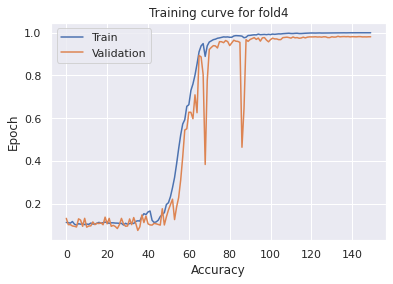

CV Accuracy Score=0.9780911609166457


In [14]:
lr = 0.01
epochs = 150
model_name = "efficientnet-b6"
optim_name = "adam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

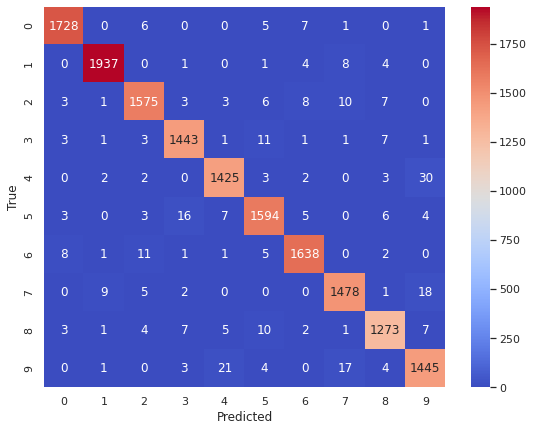

In [27]:
conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
plt.figure(figsize=(9, 7))
sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [25]:
print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1748
         1.0       0.99      0.99      0.99      1955
         2.0       0.98      0.97      0.98      1616
         3.0       0.98      0.98      0.98      1472
         4.0       0.97      0.97      0.97      1467
         5.0       0.97      0.97      0.97      1638
         6.0       0.98      0.98      0.98      1667
         7.0       0.97      0.98      0.98      1513
         8.0       0.97      0.97      0.97      1313
         9.0       0.96      0.97      0.96      1495

    accuracy                           0.98     15884
   macro avg       0.98      0.98      0.98     15884
weighted avg       0.98      0.98      0.98     15884



In [28]:
torch.cuda.empty_cache()
gc.collect()

21334

#### EfficientNet-B7

In [23]:
lr = 0.01
epochs = 130
model_name = "efficientnet-b7"
optim_name = "adam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [24]:
torch.cuda.empty_cache()
gc.collect()

Epoch=0, Accuracy=0.11142587346553352
Epoch=10, Accuracy=0.08781869688385269
Epoch=20, Accuracy=0.08781869688385269
Epoch=30, Accuracy=0.11740635819955933
Epoch=40, Accuracy=0.09977966635190431
Epoch=50, Accuracy=0.1252754170601196
Epoch=60, Accuracy=0.10324205225055083
Epoch=70, Accuracy=0.11268492288322317
Epoch=80, Accuracy=0.1022977651872836
Epoch=90, Accuracy=0.12590494176896444
Epoch=100, Accuracy=0.1252754170601196
Epoch=110, Accuracy=0.1252754170601196
Epoch=120, Accuracy=0.12653446647780925
Epoch=130, Accuracy=0.1252754170601196
Epoch=140, Accuracy=0.1252754170601196
Epoch=150, Accuracy=0.1252754170601196
Epoch=160, Accuracy=0.1252754170601196
Epoch=170, Accuracy=0.1252754170601196


KeyboardInterrupt: 

#### EfficientNet-B8

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-b8"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint, label_smooth=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [32]:
torch.cuda.empty_cache()
gc.collect()

2914

#### EfficientNet-L2

In [ ]:
lr = 0.01
epochs = 100
model_name = "efficientnet-l2"
optim_name = "radam"
checkpoint = f"./checkpoints/{model_name}-{optim_name}-lr{lr}-e{epochs}"

oof, targs = run(model_name, optim_name, epochs, lr, checkpoint)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

## Inference

In [14]:
df_test = pd.read_csv("../input/test.csv")

In [15]:
probs_test = np.zeros((len(df_test), 10))

### 1-input channel models

In [ ]:
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [ ]:
# model = models.Model()
# swa_model = AveragedModel(model)
# swa_model.load_state_dict(torch.load("../models/baseline-swa-4.pth"))
# swa_model.to(device)
# probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

In [ ]:
model = models.SpinalVGG()
swa_model = AveragedModel(model)
swa_model.load_state_dict(torch.load("../models/spinalvgg-swa-0.pth"))
swa_model.to(device)
probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

### 3-input channel models

In [16]:
test_dataset = dataset.EMNISTDataset(df_test, np.arange(len(df_test)), label=False, rgb=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512)

In [ ]:
model = ResNet18()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/resnet18-1.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

In [ ]:
model = ResNet34()
# swa_model = AveragedModel(model)
model.load_state_dict(torch.load("../models/resnet34-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

#### EfficientNet-B0

##### Vanilla

In [19]:
model = models.EfficientNetB0()
model.load_state_dict(torch.load("../models/efficientnet-b0-4.pth"))
model.to(device)
probs_test += softmax(engine.evaluate(test_loader, model, device, target=False), axis=1)

##### SWA

In [17]:
model = models.EfficientNetB0()
swa_model = AveragedModel(model)
swa_model.load_state_dict(torch.load("../models/swa-efficientnet-b0-4.pth"))
swa_model.to(device)
probs_test += softmax(engine.evaluate(test_loader, swa_model, device, target=False), axis=1)

### Submission

In [18]:
preds_test = np.argmax(probs_test, axis=1)

In [19]:
submission = pd.DataFrame({"id": df_test.id, "digit": preds_test})
submission.to_csv("../output/swa-efficientnetb0_radam003.csv", index=False)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
